In [1]:
import numpy as np

def create_embedding_matrix(word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open('180/model.txt', encoding='utf-8') as f:
        for line in f:
            word_, *vector = line.split()
            word = word_.split('_')[0]
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)

    return embedding_matrix

In [2]:
with open('180/model.txt', encoding='utf-8') as f:
    i = 0
    for line in f:
        word, *vector = line.split()
        i = i + 1 
    print(i)

189194


In [3]:
import pymorphy2
import nltk
import string
from nltk.corpus import stopwords


morph = pymorphy2.MorphAnalyzer()

stop_words = stopwords.words('russian')
stop_words.extend(['«', '»', '–', '...', '“', '”', '—', '!',
                   '@', '№', ':', ',', '.', '?', ':', '(', ')'])
stop_words = set(stop_words)

def normalize_review(review):
    """

    :param review:
    :param morph:
    :return:
    """

    tokens = nltk.word_tokenize(review)
    normalized_tokens = []
    # normalized_review = ''
    for token in tokens:
        token = morph.parse(token)[0].normal_form
        if token not in stop_words and token not in string.punctuation:
            normalized_tokens.append(token.lower())

    return " ".join(normalized_tokens)

In [5]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()

train_texts = []
with open('ALL_reviews.txt', encoding='utf-8') as f:
    for line in f:
        train_texts.append(normalize_review(line))

test_texts = []
with open('all_my_reviews.txt', encoding='utf-8') as f:
    for line in f:
        test_texts.append(normalize_review(line))

        
tokenizer.fit_on_texts(train_texts)
X_train = tokenizer.texts_to_sequences(train_texts)
X_test = tokenizer.texts_to_sequences(test_texts)

In [6]:
print(len(X_train))
print(len(X_test))
print(len(tokenizer.word_index.items()))
print(tokenizer.word_index.items())


610
90
18656
dict_items([('фильм', 1), ('это', 2), ('весь', 3), ('который', 4), ('свой', 5), ('человек', 6), ('то', 7), ('мочь', 8), ('самый', 9), ('очень', 10), ('герой', 11), ('просто', 12), ('хороший', 13), ('ещё', 14), ('история', 15), ('время', 16), ('жизнь', 17), ('главный', 18), ('10', 19), ('сюжет', 20), ('персонаж', 21), ('картина', 22), ('смотреть', 23), ('сказать', 24), ('большой', 25), ('год', 26), ('зритель', 27), ('каждый', 28), ('кино', 29), ('мир', 30), ('сцена', 31), ('стать', 32), ('актёр', 33), ('момент', 34), ('какой', 35), ('роль', 36), ('мультфильм', 37), ('режиссёр', 38), ('просмотр', 39), ('хотя', 40), ('говорить', 41), ('часть', 42), ('сделать', 43), ('тарантино', 44), ('работа', 45), ('посмотреть', 46), ('ничто', 47), ('новый', 48), ('хотеть', 49), ('конец', 50), ('имя', 51), ('нолана', 52), ('лишь', 53), ('видеть', 54), ('игра', 55), ('именно', 56), ('почему', 57), ('друг', 58), ('что', 59), ('вообще', 60), ('наш', 61), ('понравиться', 62), ('стоить', 63), ('

In [10]:
# max_len = len(tokenizer.word_index.items())
lens = [len(x) for x in X_train]
max_len = max(lens)
print(max_len)
    

from keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(X_train, maxlen=max_len)
print(len(x_train[3]))
print(x_train[3])
x_test = pad_sequences(X_test, maxlen=max_len)

1608
1608
[  0   0   0 ... 863  19  19]


In [12]:
embedding_dim = 300
embedding_matrix = create_embedding_matrix(tokenizer.word_index, embedding_dim)

In [13]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
vocab_size = len(tokenizer.word_index) + 1
nonzero_elements / vocab_size

0.7830840971217238

In [22]:
max_words = len(tokenizer.word_index.items()) + 1 #кол-во словаря токенайзера
num_classes = 3

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding, Conv1D, GlobalMaxPool1D


model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=300, input_length=max_len, weights=[embedding_matrix], trainable=False))
model.add(Conv1D(128, 3))
model.add(Activation("relu"))
model.add(GlobalMaxPool1D())
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1608, 300)         5597100   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1606, 128)         115328    
_________________________________________________________________
activation_3 (Activation)    (None, 1606, 128)         0         
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 387       
_________________________________________________________________
activation_4 (Activation)    (None, 3)                 0         
Total params: 5,712,815
Trainable params: 115,715
Non-trainable params: 5,597,100
______________________________________

In [23]:
print(model.metrics_names)


['loss', 'accuracy']


In [24]:
import pandas
excel_file = pandas.read_excel('Отзывы кино.xlsx', 0)

# Оценки для отзывов
Y_train = []

for i, row in excel_file.iterrows():
    if (row['title'] != 'Криминальное чтиво' and
        row['title'] != 'Маленькая Мисс Счастье' and
        row['title'] != 'Амели'):
        Y_train.append(row['label'])
        
Y_test = []

for i, row in excel_file.iterrows():
    if (row['title'] == 'Криминальное чтиво' or
        row['title'] == 'Маленькая Мисс Счастье' or
        row['title'] == 'Амели'):
        Y_test.append(row['label'])
        
print(len(Y_train))
print(len(Y_test))

610
90


In [25]:
import keras
y_train = keras.utils.to_categorical(Y_train, num_classes)
y_test = keras.utils.to_categorical(Y_test, num_classes)

print(x_train.shape)
print(x_test.shape)

print(y_train.shape)
print(y_test.shape)

(610, 1608)
(90, 1608)
(610, 3)
(90, 3)


In [26]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score


Train on 610 samples, validate on 90 samples
Epoch 1/10
610/610 [==============================] - 6s 9ms/step - loss: 1.8882 - accuracy: 0.3705 - val_loss: 1.3798 - val_accuracy: 0.3667
Epoch 2/10
610/610 [==============================] - 5s 9ms/step - loss: 0.4694 - accuracy: 0.8557 - val_loss: 1.1854 - val_accuracy: 0.3778
Epoch 3/10
610/610 [==============================] - 5s 9ms/step - loss: 0.1990 - accuracy: 0.9885 - val_loss: 1.2294 - val_accuracy: 0.3889
Epoch 4/10
610/610 [==============================] - 5s 9ms/step - loss: 0.1182 - accuracy: 0.9984 - val_loss: 1.2350 - val_accuracy: 0.3889
Epoch 5/10
610/610 [==============================] - 5s 9ms/step - loss: 0.0805 - accuracy: 0.9967 - val_loss: 1.2125 - val_accuracy: 0.3889
Epoch 6/10
610/610 [==============================] - 5s 9ms/step - loss: 0.0660 - accuracy: 0.9984 - val_loss: 1.2088 - val_accuracy: 0.4000
Epoch 7/10
610/610 [==============================] - 5s 9ms/step - loss: 0.0551 - accuracy: 0.9984 - v

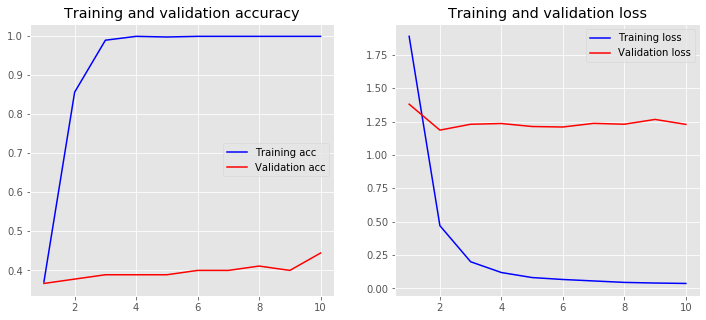

In [27]:
history = model.fit(x_train, y_train,
                    epochs=10,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    batch_size=32)
loss, accuracy = model.evaluate(x_train, y_train, verbose=1)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

predictions = model.predict(x_test)

act_classes = [1]*30 + [-1]*30 + [0]*30
import numpy as np

labels = {
    0: 0,
    1: 1,
    2: -1
}

pred_classes = [labels[np.argmax(x)] for x in predictions]

print("CNN 10 Accuracy Score -> ",accuracy_score(pred_classes, act_classes)*100)
print(precision_recall_fscore_support(act_classes, pred_classes, average='weighted'))



Train on 610 samples, validate on 90 samples
Epoch 1/20
610/610 [==============================] - 6s 9ms/step - loss: 0.0265 - accuracy: 0.9984 - val_loss: 1.2428 - val_accuracy: 0.4000
Epoch 2/20
610/610 [==============================] - 5s 9ms/step - loss: 0.0350 - accuracy: 0.9967 - val_loss: 1.2386 - val_accuracy: 0.4667
Epoch 3/20
610/610 [==============================] - 5s 9ms/step - loss: 0.0241 - accuracy: 0.9967 - val_loss: 1.2388 - val_accuracy: 0.4444
Epoch 4/20
610/610 [==============================] - 5s 9ms/step - loss: 0.0280 - accuracy: 0.9967 - val_loss: 1.2559 - val_accuracy: 0.4333
Epoch 5/20
610/610 [==============================] - 5s 9ms/step - loss: 0.0224 - accuracy: 0.9967 - val_loss: 1.2358 - val_accuracy: 0.4556
Epoch 6/20
610/610 [==============================] - 5s 9ms/step - loss: 0.0226 - accuracy: 0.9984 - val_loss: 1.2902 - val_accuracy: 0.4556
Epoch 7/20
610/610 [==============================] - 5s 9ms/step - loss: 0.0253 - accuracy: 0.9984 - v

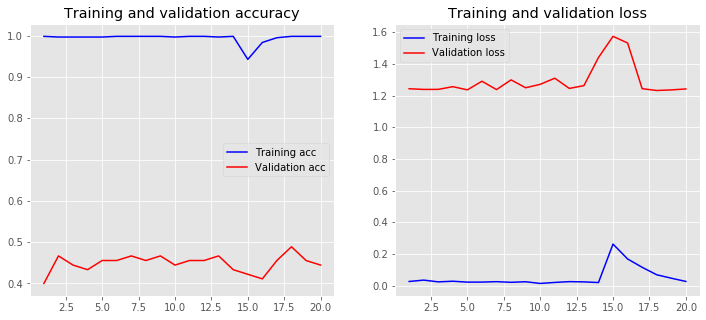

In [28]:
# 20 epochs

history = model.fit(x_train, y_train,
                    epochs=20,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    batch_size=32)
loss, accuracy = model.evaluate(x_train, y_train, verbose=1)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
print("Testing Accuracy:  {:.4f}".format(accuracy))

plot_history(history)

predictions = model.predict(x_test)

pred_classes = [labels[np.argmax(x)] for x in predictions]

print("CNN 20 Accuracy Score -> ",accuracy_score(pred_classes, act_classes)*100)
print(precision_recall_fscore_support(act_classes, pred_classes, average='weighted'))



Train on 610 samples, validate on 90 samples
Epoch 1/30
610/610 [==============================] - 5s 9ms/step - loss: 0.0213 - accuracy: 0.9967 - val_loss: 1.2903 - val_accuracy: 0.5111
Epoch 2/30
610/610 [==============================] - 5s 9ms/step - loss: 0.0112 - accuracy: 0.9984 - val_loss: 1.4025 - val_accuracy: 0.4556
Epoch 3/30
610/610 [==============================] - 5s 9ms/step - loss: 0.0168 - accuracy: 0.9984 - val_loss: 1.2850 - val_accuracy: 0.4778
Epoch 4/30
610/610 [==============================] - 5s 9ms/step - loss: 0.0094 - accuracy: 0.9984 - val_loss: 1.4322 - val_accuracy: 0.4556
Epoch 5/30
610/610 [==============================] - 5s 9ms/step - loss: 0.0218 - accuracy: 0.9984 - val_loss: 1.2886 - val_accuracy: 0.5111
Epoch 6/30
610/610 [==============================] - 5s 9ms/step - loss: 0.0179 - accuracy: 0.9967 - val_loss: 1.2872 - val_accuracy: 0.5111
Epoch 7/30
610/610 [==============================] - 5s 9ms/step - loss: 0.0255 - accuracy: 0.9967 - v

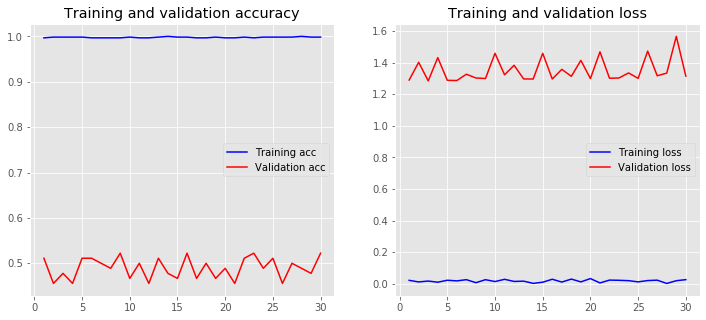

In [30]:
# 30 epochs

history = model.fit(x_train, y_train,
                    epochs=30,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    batch_size=32)
loss, accuracy = model.evaluate(x_train, y_train, verbose=1)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
print("Testing Accuracy:  {:.4f}".format(accuracy))

plot_history(history)

predictions = model.predict(x_test)

pred_classes = [labels[np.argmax(x)] for x in predictions]

print("CNN 30 Accuracy Score -> ",accuracy_score(pred_classes, act_classes)*100)
print(precision_recall_fscore_support(act_classes, pred_classes, average='weighted'))
